In [25]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pylab as plt
from scipy.stats import norm as awgn
from numpy.linalg import inv

array([[307,  19,  50, ...,  -1,  -1,  -1],
       [ 76,  -1,  76, ...,  -1,  -1,  -1],
       [205, 250, 328, ...,  -1,  -1,  -1],
       ...,
       [ -1, 113,  -1, ...,   0,  -1,  -1],
       [ 80,  -1,  -1, ...,  -1,   0,  -1],
       [ -1, 135,  -1, ...,  -1,  -1,   0]])

array([[False, True, False, ..., False, False, False],
       [False, False, True, ..., False, False, False],
       [True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., True, False, False],
       [False, False, False, ..., False, True, False],
       [False, False, False, ..., False, False, True]], dtype=object)

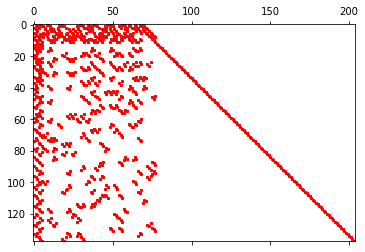

In [7]:
def get_submatrix(offset, Z):
    if offset == -1: return np.zeros((Z, Z), dtype = bool)
    offset %= Z
    if offset == 0: return np.eye(Z, dtype = bool)
    return sp.diags([np.ones(offset), np.ones(Z - offset)],
                    [offset - Z, offset], dtype = bool).toarray()

Z = 3
filler = np.vectorize(get_submatrix, otypes = [np.ndarray], signature = '()->(n,n)', excluded = (1,))
matrix = np.loadtxt('matrices/R1-1711982_BG1_set1.csv', dtype = int)
display(matrix)
H = np.block([[x for x in row] for row in filler(matrix, Z)])


plt.spy(H, markersize = 2, color = 'r')

In [61]:
#5G method https://ieeexplore.ieee.org/document/8882079

def H_disassemble(H, Z):
    m, n = H.shape
    g = 4*Z

    C = H[:g, :(n-m)]
    D = H[:g, (n-m):(n-m)+(g)]
    E = H[:g, (n-m)+(g):]
    A = H[g:, :(n-m)]
    B = H[g:, (n-m):(n-m)+(g)]
    T = H[g:, (n-m)+(g):]

    assert C.shape[1] + D.shape[1] + E.shape[1] == n
    assert A.shape[1] + B.shape[1] + T.shape[1] == n
    assert C.shape[0] + A.shape[0] == m
    assert D.shape[0] + B.shape[0] == m
    assert E.shape[0] + T.shape[0] == m
    assert sum(sum(E)) == 0
    assert sum(sum(np.eye(m - g) - T)) == 0

    D_inv = inv(D.astype(int))
    F = (D_inv @ C % 2).astype(bool)
    
    return F, A, B

def get_codevector(F, A, B, seed = 2021):
    np.random.seed(seed = seed)
    s = np.random.randint(low = 0, high = 2, size = F.shape[1])

    p_1 = F @ s.T % 2
    p_2 = (A @ s.T + B @ p_1) % 2

    d = np.hstack((s, p_1, p_2))
    return d #len(d) = 68 * Z
    
F, A, B = H_disassemble(H, Z)
d = get_codevector(F, A, B)

In [3]:
#old method

def my_permutation(B, permut, n1, n2, n3):
    v1 = B.take(n1, axis = 1)
    v2 = B.take(n2, axis = 1)
    index1, index2 = permut[n1], permut[n2]
    permut[n1], permut[n2] = index2, index1
    for i in range(v1.shape[0]):
        B[i][n2] = v1[i]
        B[i][n1] = v2[i]
        
    ones_in_n2 = list(np.where(v1 == 1)[0])
    ones_in_n2.remove(n3)
    for i in ones_in_n2:
        B[:][i] = (B[:][i] + B[:][n3]) % 2

        
def custom_gauss_elimination(H):
    B = np.copy(H)
    completed_indexes = [] 
    drop_indexes = []
    K = B.shape[0]
    N = B.shape[1]
    permut = np.arange(N)
    for k_iter in range(K):
        row = B.take(k_iter, axis = 0)
        if(sum(row) != 0):
            i = 0
            while(row[i] != 1):
                i+=1
            my_permutation(B, permut, i, N - K + k_iter, k_iter)
            completed_indexes.append(N - K + k_iter)
        else:
            drop_indexes.append(k_iter)
            
    if not drop_indexes: 
        return B, permut
    else:
        i = 0
        for drop in drop_indexes:
            H = np.delete(H, drop - i, axis=0)
            i+=1
        print("try again...")
        custom_gauss_elimination(H)
        
        
def H2G(H):
    B, permut = custom_gauss_elimination(H)
    assert B[:, -B.shape[0]:].all() == np.eye(B.shape[0], dtype = int).all()

    M = np.shape(H)[0] # N-K
    N = np.shape(H)[1] 
    K = N - M
    G = np.concatenate([np.eye(K), ((-1)*B[:, :K].T %2)], axis=1).astype(bool)
    
    A = np.copy(H)
    for j in range(H.shape[1]):
        h = H.take(permut[j], axis = 1)
        A[:, j] = h[:]
            
    assert (G @ A.T % 2).all() == np.zeros((K, K)).all()
    return G, A

G, A = H2G(H)

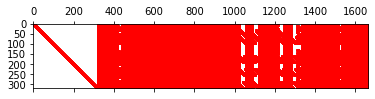

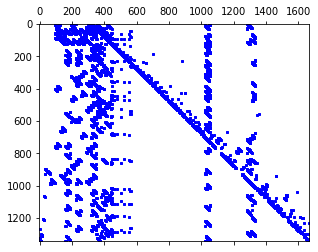

In [6]:
plt.spy(G, markersize = 2, color = 'r')
plt.show()
plt.spy(A, markersize = 2, color = 'b')
plt.show()

In [7]:
max(np.sum(H, axis = 0))

23

In [387]:
v_nodes_values = np.zeros(A.shape[1])
for c_node in range(A.shape[0]):
    v_node_list = np.where(A.take(c_node, axis = 0) == 1)[0]

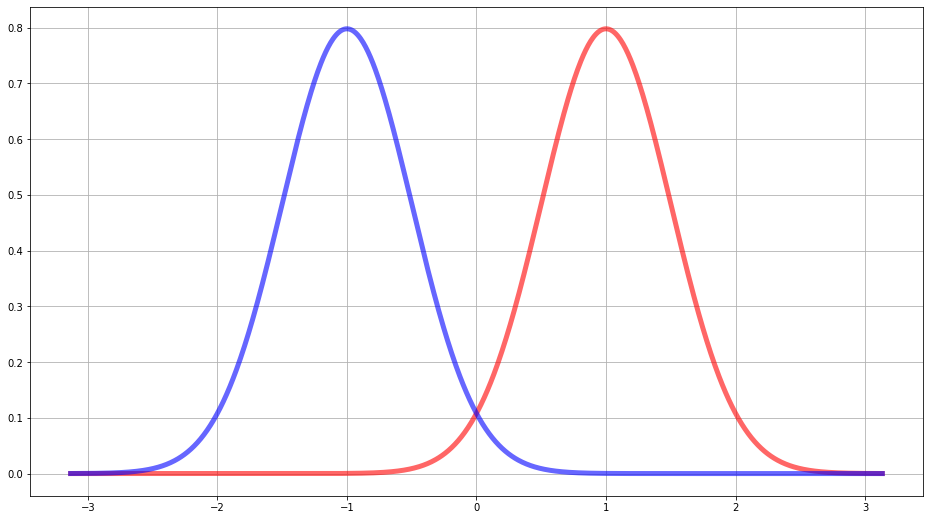

array([0.93476196, 1.11820958, 1.21316386])

In [388]:
sigma  = 0.5
args0 = {'loc': 1,  'scale': sigma}
args1 = {'loc': -1, 'scale': sigma}

x = np.linspace(awgn.ppf(1e-5, **args1),
                awgn.ppf(1 - 1e-5, **args0), 1000)

plt.figure(figsize=(16,9))
plt.plot(x, awgn.pdf(x, **args0), 'r-', lw=5, alpha=0.6, label='0')
plt.plot(x, awgn.pdf(x, **args1), 'b-', lw=5, alpha=0.6, label='1')
plt.grid()
plt.show()

awgn.rvs(size = 3, **args0)

In [389]:
def get_graph(H):
    v_graph = np.array([dict() for x in range(H.shape[1])])
    c_graph = np.array([dict() for x in range(H.shape[0])])

    for v_iter in range(H.shape[1]):
        v_graph[v_iter] = {'c_idx': np.where(H.take(v_iter, axis = 1) == 1)[0]}

    for c_iter in range(H.shape[0]):
        c_graph[c_iter] = {'v_idx': np.where(H.take(c_iter, axis = 0) == 1)[0]}
        
    return v_graph, c_graph

v_graph, c_graph = get_graph(A)

In [8]:
def MSA(H, y, SNR, max_iter = 10, threshold = 0.5):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    sigma = 10 ** (- SNR / 20)
    r = y * (2. / sigma ** 2)
    belief = r
    
    L = np.copy(H).astype(float)
    
    #initialization
    for i in range(L.shape[0]):
        L[i, :] = (L[i, :] > 0) * belief[:]

    for k in range(max_iter):
        print(k)
        #row step
        for i in range(L.shape[0]):
            magnitudes = sorted(set(abs(L[i])), reverse = False)
            magnitudes.remove(0)
            min1, min2 = list(magnitudes)[:2]
            argmin1 = np.where(abs(L[i]) == min1)[0]
            signs = np.sign(L[i])
            parity = np.sum(signs < 0) % 2

            L[i] = (L[i] != 0) * min1
            L[i][argmin1] = min2
            L[i] *= signs * (-1) ** parity

        #column step
        belief = np.sum(L, axis = 0) + r
        L = (H != 0) * (belief - L)
        
        if (sum(H @ demodulate(belief) % 2) == 0):
            return belief
        if (np.prod(np.abs(belief) > threshold)):
            return belief
        
    return belief

def demodulate(b):
    u = 0.5 * (1 - np.sign(b))
    return u.astype(bool)

def modulate(v):
    return 1 - 2*v

def encoder(G, v, SNR, seed = 2021):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    # BPSK modulation: "0" -> +1., "1" -> -1.
    
    x = modulate(v)
    
    sigma = 10 ** (- SNR / 20)
    np.random.seed(seed = seed)
    e = awgn.rvs(size = x.shape, scale = sigma)
    
    y = x + e
    return y


def decoder(H, y, SNR, alg = 'MSA'):
    if alg == 'MSA':
        b = MSA(H, y, SNR = SNR)
    elif alg == 'SPA':
        b = SPA(H, y, SNR = SNR)
    else:
        print('unknown alg'); return np.zeros(y.shape).astype(bool)
    
    u = demodulate(b)
    
    s = H @ u % 2
    if sum(s) != 0: print('probably there is an error')
    return u

@np.vectorize
def custom_llr(val):
    if abs(val) == 1.: return val
    return np.log((1 + val)/(1 - val))

def SPA(H, y, SNR, max_iter = 10, threshold = 0.5):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    sigma = 10 ** (- SNR / 20)
    r = y * (2. / sigma ** 2)
    
    M = np.copy(H).astype(float)
    E = np.zeros(H.shape)
    H_inv = (H + np.ones(np.shape(H))) %2

    for i in range(H.shape[0]):
        M[i, :] = r * H[i, :]

    for k in range(max_iter):
        #print(k)
        
        M = np.tanh(M/2) + H_inv
        t = np.prod(M, axis = 1) 
        for j in range(H.shape[1]):
            E[:, j] = t * H[:, j]
        E[:,:] = E[:, :] / M[:, :]
        E = H*E
        E = custom_llr(E)

        belief = np.sum(E, axis = 0) + r
        #print(belief)
        M = (H != 0) * (belief - E)

        if (sum(H @ demodulate(belief) % 2) == 0):
            return belief
        if (np.prod(np.abs(belief) > threshold)):
            return belief
        
    return belief

In [12]:
a = np.random.randint(low = 0, high = 2, size = G.shape[0])
v = (a @ G % 2).astype(bool)

SNR = 8
for n in range(5):
    y = encoder(G = G, v = v, SNR = SNR, seed = n)
    u = decoder(H = A, y = y, SNR = SNR, alg = 'SPA')

    print(np.allclose(u, v))

probably there is an error
False
probably there is an error
False
probably there is an error
False
True
probably there is an error
False


In [393]:
%load_ext line_profiler
%lprun -T lprof0 -f MSA MSA(H = A, y = y, SNR = SNR, max_iter = 100)
print(open('profile', 'r').read())

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
0
1

*** Profile printout saved to text file 'lprof0'. 
Timer unit: 1e-06 s

Total time: 353.067 s
File: <ipython-input-183-545bcc01bc3d>
Function: SPA at line 78

Line #      Hits         Time  Per Hit   % Time  Line Contents
    78                                           def SPA(H, y, SNR, max_iter = 10, threshold = 0.5):
    79                                               # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    80         1          5.0      5.0      0.0      sigma = 10 ** (- SNR / 20)
    81         1         24.0     24.0      0.0      r = y * (2. / sigma ** 2)
    82                                               
    83         1      16037.0  16037.0      0.0      M = np.copy(H).astype(float)
    84         1      72181.0  72181.0      0.0      H_inv = (H + np.ones(np.shape(H))) %2
    85                                               
    8

In [5]:
y = np.array([-0.1, 0.5, -0.8, 1.0, -0.7, 0.5])
SNR = 0.9691
sigma = 10 ** (- SNR / 20)
r = y * (2. / sigma ** 2)
r

array([-0.49999999,  2.49999993, -3.99999988,  4.99999985, -3.4999999 ,
        2.49999993])